<a href="https://colab.research.google.com/github/TrentBrick/PAE/blob/master/PreAttention_PyTorch_txt_based_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Data conversion to integers and keras models are at the bottom of the whole script!!


In [20]:
import torch
print(torch.__version__)
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive') #, force_remount=True)

1.0.1.post2
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [21]:
cd gdrive

[Errno 2] No such file or directory: 'gdrive'
/content/gdrive/My Drive


In [22]:
cd My\ Drive

[Errno 2] No such file or directory: 'My Drive'
/content/gdrive/My Drive


# Start

In [0]:
import pickle

primary_train = pickle.load(open('training_primary_ints.pickle', 'rb'))#+1
primary_test = pickle.load(open('testing_primary_ints.pickle', 'rb'))#+1
primary_cv = pickle.load(open('validation_primary_ints.pickle', 'rb'))#+1

#sequence_of_int = pickle.load(open('sequence_of_int.pickle', 'rb'))
#pickle.dump(sequence_of_int, open('sequence_of_int.pickle', 'wb'))

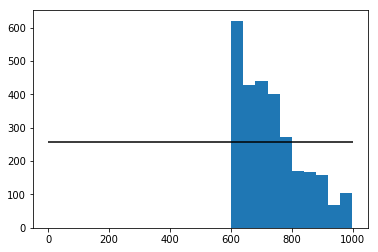

In [53]:
lens=[]
for p in primary_train:
    if p.shape[0] > 600:
        lens.append(p.shape[0])
    
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
    
plt.hist(lens, label='numbers at each length')
plt.hlines(256,0,1000)
plt.show()

In [24]:
primary_test.shape

(40,)

In [25]:
primary_train[0]

array([16,  2, 13,  0,  0,  4,  2, 16, 11,  7, 17, 16,  9, 16, 14,  4, 17,
       10,  3,  3,  5, 10,  8,  0, 14,  5, 16,  5,  3, 10, 16, 13,  9,  9,
       11, 15,  9,  1, 16,  0, 17,  8,  0,  7, 15, 16,  0, 17, 14,  8,  0,
        5,  7,  0,  6,  9, 19,  5,  7,  0,  5, 15, 16, 11, 17, 16,  5,  2,
       13, 17,  8,  8,  9,  2, 17,  9, 15, 11,  2,  9, 17,  7, 11, 17,  9,
        8, 15, 15,  4,  0, 16,  1, 17,  9, 17, 15,  3,  3,  2,  8, 11,  0,
        7,  7, 17,  3, 12,  3,  8, 14,  5,  8, 19, 17, 17,  1,  4,  2, 12,
        9,  2,  5, 15, 15, 11,  7,  2,  1,  9, 17, 15,  7,  5, 16,  7,  4,
        5,  7, 19, 14,  8, 11, 15, 16,  2,  3, 12, 15,  3,  8,  2,  0,  9,
       13, 12,  5, 14, 11,  9, 17,  0,  0,  5, 19,  0,  9, 19,  5, 15,  0,
       16, 10,  9, 17,  9,  0, 10, 17, 11,  5, 17, 11,  1,  4, 10,  9,  2,
       12,  0,  7,  5,  3,  4,  7,  9, 17,  2, 14,  2, 17,  8,  7,  8,  8,
        8,  5, 15,  7, 19, 15,  7, 11,  3,  5, 19,  0,  8,  3,  4,  2, 12,
        0,  7, 16,  3, 19

In [0]:

lengths = []
for s in primary_train: 
    lengths.append(len(s))
import numpy as np
#average length
sum(lengths)/len(lengths)
primary_train = primary_train[np.array(lengths) < 1000]


lengths = []
for s in primary_cv: 
    lengths.append(len(s))
import numpy as np
#average length
sum(lengths)/len(lengths)
primary_cv = primary_cv[np.array(lengths) < 1000]

In [27]:
primary_cv.shape

(224,)

In [28]:
primary_train[1]

array([15,  2,  9, 12,  0,  9, 15, 16,  5,  9,  9,  6,  9,  6, 13, 11,  7,
       17,  2, 17, 13, 19, 10, 19,  5,  9, 15, 12,  0,  7, 16,  8, 19, 17,
       17, 14])

In [0]:
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html 
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Sampler

# I DONT ACTUALLY USE ANY OF THIS!!!!

class PrimarySequences(Dataset):
    def __init__(self, dataset):
        self.sequences = dataset

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.sequences[idx].shape[0] 
  

In [30]:
primary_train[0].shape

(337,)

In [0]:
df_train = PrimarySequences(primary_train)
df_cv = PrimarySequences(primary_cv)

In [0]:
# https://discuss.pytorch.org/t/tensorflow-esque-bucket-by-sequence-length/41284/4 buckets things of only the exact same size. 

from collections import OrderedDict
import numpy as np
from random import shuffle

class BucketDataset(Sampler):
    # want inputs to be an array
    def __init__(self, inputs, batch_size):
        self.inputs = inputs      # shape = (N, max_seq_len)
        self.targets = None    # shape = (N, ) or None (e.g., for autoencoder I can simply use inputs)
        self.batch_size = batch_size
        ind_n_len = []
        for i, p in enumerate(inputs):
            ind_n_len.append( (i, p.shape[0]) )
        self.ind_n_len = ind_n_len
        
    def _generate_batch_map(self, equal_length=False):
        
        shuffle(self.ind_n_len) # shuffle all of the indices first so they are put into buckets differently
        
        batch_map = OrderedDict()
        # Organize lengths, e.g., batch_map[10] = [30, 124, 203, ...] <= indices of sequences of length 10
        for idx, length in self.ind_n_len:
            if length not in batch_map:
                batch_map[length] = [idx]
            else:
                batch_map[length].append(idx)
        # Use batch_map to split indices into batches of equal size
        # e.g., for batch_size=3, batch_list = [[23,45,47], [49,50,62], [63,65,66], ...]
        batch_list = []
        for length, indices in batch_map.items():
            for group in [indices[i:(i+self.batch_size)] for i in range(0, len(indices), self.batch_size)]:
                batch_list.append(group)
        return batch_list

    def batch_count(self):
        return len(self.batch_list)

    def __len__(self):
        return len(self.lengths)

    def __iter__(self):

        batch_list = self._generate_batch_map()
        
        shuffle(batch_list) # shuffle all the batches so they arent ordered by bucket size
        for i in batch_list: 
            yield i 
        

In [0]:
def one_hotter(DataLoaderBatch):
    
    batch_split = list(zip(*DataLoaderBatch))
    seqs, lengths = batch_split[0], batch_split[1]
    
    vocab_size = 20
    batch_size = len(DataLoaderBatch)
    max_length = lengths[0] # as all the lengths are the same in my case here! else take the max(lengths)
    
    y = torch.tensor(seqs).type(torch.LongTensor) #had device
    y_onehot = torch.FloatTensor(batch_size, max_length, vocab_size)
    y_onehot.zero_()
    y_onehot.scatter_(2, torch.unsqueeze(y, 2), 1.0)
    #print('max')
    #print(y_onehot.max(dim=2)[1])
    return y_onehot, torch.tensor(lengths)

# Encoder and Decoder

In [36]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class EncoderNet(nn.Module):

    def __init__(self, ENCODING_LSTM_OUTPUT=100, CODE_LAYER_SIZE=50, VOCAB_SIZE=20, ENCODER_LSTM_NUM_LAYERS=2 ):
        super(EncoderNet, self).__init__()
        #encoding
        self.LSTM_NUM_LAYERS = ENCODER_LSTM_NUM_LAYERS
        self.ENCODING_LSTM_OUTPUT = ENCODING_LSTM_OUTPUT
        self.encoder = nn.LSTM(input_size=VOCAB_SIZE, hidden_size= self.ENCODING_LSTM_OUTPUT,num_layers=self.LSTM_NUM_LAYERS,bidirectional=True, batch_first=True)
        #self.batchnorm = nn.BatchNorm1d(ENCODING_LSTM_OUTPUT * 2* self.LSTM_NUM_LAYERS) # as either 2 layers OR I concat them
        self.dense1_enc = nn.Linear(in_features=(ENCODING_LSTM_OUTPUT* 2 ), out_features=CODE_LAYER_SIZE ) # * self.LSTM_NUM_LAYERS because it is bidirectional
        self.dense2_enc = nn.Linear(in_features=CODE_LAYER_SIZE, out_features=CODE_LAYER_SIZE )
        if self.LSTM_NUM_LAYERS >2:
            print('WARNING, LSTM ENCODER HAS MORE THAN 2 LAYER, will need to change how hidden layers are concatenated!')

    def forward(self, input, seq_len):
        #print('encoder input', input)
        #print('sequence length', seq_len)
        # Pack padded batch of sequences for RNN module
        #res = torch.nn.utils.rnn.pack_padded_sequence(input, seq_len, batch_first=True).cuda()
        res, (hidden_h, hidden_c) = self.encoder(input)
        #res = torch.nn.utils.rnn.pad_packed_sequence(res, batch_first=True).cuda() # only use if I want the output w/ all timesteps for the LSTM
        # combine the bidirectional outputs, concatenate states from separate layers. 
        #print('hidden encoder that i concat', hidden_h.shape)
        
        res = torch.mean(res, dim=1)
        
        #res = res.view(self.LSTM_NUM_LAYERS, 2, input.shape[0], self.ENCODING_LSTM_OUTPUT)
        
        '''if self.LSTM_NUM_LAYERS ==2:
            #res = hidden_h.view(self.LSTM_NUM_LAYERS, 2, input.shape[0], self.ENCODING_LSTM_OUTPUT)
            
            # may be much more efficient ways to do this:
            res = torch.cat( (torch.cat( (res[0,0,:,:], res[0,1,:,:]) ,1), torch.cat( (res[1,0,:,:], res[1,1,:,:]) ,1) ), 1)
            #res= torch.cat( (torch.add(torch.mean(res[0,:,:], dim=),hidden_h[1,:,:]),torch.add(hidden_h[2,:,:],hidden_h[3,:,:])), 1)
        else: 
            # average over all of the hidden states!
            print(res.shape)
            # res = torch.mean( res, dim=1)
            torch.cat((hidden_h[0,:,:],hidden_h[1,:,:]), 1) '''
        #res = self.batchnorm(res)
        res = self.dense2_enc(F.elu(self.dense1_enc(res))) # used to have F.tanh here!
        return res

encoder_net = EncoderNet()
print(encoder_net)

EncoderNet(
  (encoder): LSTM(20, 100, num_layers=2, batch_first=True, bidirectional=True)
  (dense1_enc): Linear(in_features=200, out_features=50, bias=True)
  (dense2_enc): Linear(in_features=50, out_features=50, bias=True)
)


In [37]:
class DecoderNet(nn.Module):

    def __init__(self, DECODING_LSTM_OUTPUT=100, CODE_LAYER_SIZE=50, VOCAB_SIZE=20, DECODER_LSTM_NUM_LAYERS=1 ):
        super(DecoderNet, self).__init__()
        #decode it should be the inverse of the encoder!
        #self.dense1_predecode = nn.Linear(in_features=(CODE_LAYER_SIZE), out_features=50 )
        #self.dense1_pre_dec = nn.Linear(in_features=(CODE_LAYER_SIZE), out_features=200 )
        self.LSTM_OUTPUT_SIZE = DECODING_LSTM_OUTPUT
        #self.decoder_out = nn.LSTM(input_size=int(CODE_LAYER_SIZE/2),bidirectional=False, hidden_size=VOCAB_SIZE,num_layers=1, batch_first=True)
        self.LSTM_NUM_LAYERS=DECODER_LSTM_NUM_LAYERS
        self.CODE_LAYER_SIZE=CODE_LAYER_SIZE
        self.VOCAB_SIZE=VOCAB_SIZE
        self.decoder = nn.LSTM(input_size=CODE_LAYER_SIZE,bidirectional=True, 
                               hidden_size=self.LSTM_OUTPUT_SIZE,num_layers=self.LSTM_NUM_LAYERS, batch_first=True)
        # should be half the size but the LSTM is bidirectional. 
        #self.batchnorm = nn.BatchNorm1d(self.LSTM_OUTPUT_SIZE)
        #self.dense1_post_dec = nn.Linear(in_features=(self.LSTM_OUTPUT_SIZE), out_features=50 )
        self.dense2_post_dec = nn.Linear(in_features=self.LSTM_OUTPUT_SIZE*2, out_features=VOCAB_SIZE )
        #self.dense3_post_dec = nn.Linear(in_features=50, out_features=VOCAB_SIZE )

    def forward(self, latent_space, prev_out, hidden):
        #decoding. takes in a single latent code from a single part of the batch. 
        # where input is the teacher forcing or the predictions from the previous step.

        prev_out, hidden = self.decoder(latent_space)
        
        #print('batch norm ', prev_out.shape)
        #prev_out = self.batchnorm(prev_out.permute([0,2,1])).permute([0,2,1]).contiguous()
        #print('batch norm ', prev_out.shape)
        #prev_out = F.elu(self.dense1_post_dec(prev_out))
        prev_out = F.log_softmax(self.dense2_post_dec(prev_out), dim=2)
        
        return prev_out, hidden
    
    def initHidden(self, batch_size):
        hidden_h = torch.empty([self.LSTM_NUM_LAYERS,batch_size,int(self.LSTM_OUTPUT_SIZE)], device=device)
        torch.nn.init.orthogonal_(hidden_h, gain=nn.init.calculate_gain('tanh'))
        return (hidden_h,
                torch.zeros([self.LSTM_NUM_LAYERS,batch_size,int(self.LSTM_OUTPUT_SIZE)], device=device))

'''   def initHidden_Out(self, batch_size):
        return (torch.zeros([1,batch_size,self.VOCAB_SIZE], device=device),
                torch.zeros([1,batch_size,self.VOCAB_SIZE], device=device))'''

decoder_net = DecoderNet()
print(decoder_net)

DecoderNet(
  (decoder): LSTM(50, 100, batch_first=True, bidirectional=True)
  (dense2_post_dec): Linear(in_features=200, out_features=20, bias=True)
)


# Useful functions

In [0]:
import time
import math
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))




In [0]:
def printParamNum(encoder_net, decoder_net):
    params=0
    for net in [encoder_net, decoder_net]:
        model_parameters = filter(lambda p: p.requires_grad, net.parameters())
        params += sum([np.prod(p.size()) for p in net.parameters()])
    print('total model parameters: ',params)

In [40]:
'''params=0
net= encoder_net
model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params += sum([np.prod(p.size()) for p in net.parameters()])
print('total model parameters: ',params)'''

"params=0\nnet= encoder_net\nmodel_parameters = filter(lambda p: p.requires_grad, net.parameters())\nparams += sum([np.prod(p.size()) for p in net.parameters()])\nprint('total model parameters: ',params)"

In [0]:
def saveModel(encoder_net, decoder_net,encoder_optimizer, decoder_optimizer, save_name, train_loss, eval_acc, e):
    for name, net, optim in zip(['encoder_save','decoder_save'],[encoder_net, decoder_net],[encoder_optimizer, decoder_optimizer] ):
        torch.save({
                    'epoch': e,
                    'model_state_dict': net.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'last_loss': train_loss,
                    'eval_accuracy':eval_acc
                    }, save_name+name+'.tar')
    print('saveModel worked')

In [0]:
def loadModel(encoder_net, decoder_net,encoder_optimizer, decoder_optimizer, load_name, ignore_optim=False):
    #ignore optim is for when I am loading in a model to assess predictions and not training it anymore. 
    for name, net, optim in zip(['encoder_save','decoder_save'],[encoder_net, decoder_net],[encoder_optimizer, decoder_optimizer] ):
        checkpoint = torch.load(load_name+name+'.tar')
        state = checkpoint['model_state_dict'] #.state_dict()
        #state.update(net.state_dict())
        net.load_state_dict(state)#checkpoint['model_state_dict'])
        if not ignore_optim:
            optim.load_state_dict(checkpoint['optimizer_state_dict'])
        e = checkpoint['epoch']
        loss = checkpoint['last_loss']
        best_eval_acc = checkpoint['eval_accuracy']
    print('loaded in previous model!')
    return encoder_net, decoder_net,encoder_optimizer, decoder_optimizer, loss, e, best_eval_acc

In [0]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
        m.bias.data.fill_(0.01)
    elif type(m) == nn.LSTM:
        for name, param in m.named_parameters():
            if 'weight' in name:
                torch.nn.init.xavier_uniform_(param, gain=nn.init.calculate_gain('tanh'))
            if 'bias' in name:
                param = torch.zeros(param.shape)
                

In [0]:
def save_weights(m):
    save_init_weights = dict()
    for name, param in m.named_parameters():
        save_init_weights[name] = param
    return save_init_weights

In [0]:
def cross_entropy_one_hot(Y_hat, Y):
    criterion = torch.nn.NLLLoss(size_average=True, ignore_index=-1)
    loss=  criterion(Y_hat.permute([0,2,1]).contiguous(), Y.max(dim=2)[1])
    #print('y shape', Y.shape)
    
    # flatten all the labels
    Y = Y.max(dim=2)[1].view(-1)
    Y_hat = Y_hat.view(-1, VOCAB_SIZE)
    #mask = (Y > 0).float()
    nb_tokens = Y.shape[0]#int(torch.sum(mask).item())
    #get accuracy
    top_preds = Y_hat.max(dim=1)[1]
    acc = torch.sum( torch.eq(top_preds, Y).type(torch.cuda.FloatTensor))/nb_tokens  #*mask) / nb_tokens
    #Y_hat = Y_hat[torch.arange(Y_hat.shape[0]), Y]* mask
    
    return loss, acc
    

In [0]:
def train_forward(encoder_net, decoder_net, seqs, lengths, device, readout=True, teacher_forcing=False, make_preds=False, print_preds=False ):
  
    latent = encoder_net(seqs,lengths)
    
    batch_size = seqs.shape[0]
    max_l = torch.max(lengths)
    hidden = decoder_net.initHidden(batch_size)
    
    # need to give each of the latents a time step proportional to their length number. 
    # get rid of the time STEPS IF DOING TEACHER FORCING AND INCREMENT THE INPUTS BY ONE!
    if(readout==True): 

        batch_outs = torch.zeros([batch_size,max_l, VOCAB_SIZE], device=device, requires_grad=False)
        
        # if another LSTM need to add this one and another one. 
        #hidden_out = decoder_net.initHidden_Out(batch_size)
        
        if (not teacher_forcing):
            #time_steps=1
            prev_out = torch.zeros([batch_size,1, 1], device=device, requires_grad=False)
            latent = latent.view(latent.shape[0],1,latent.shape[1])
            for t in range(max_l):
                prev_out, hidden = decoder_net(latent, prev_out, hidden)
                #print('is prev out requires grad? ', prev_out.requires_grad)
                batch_outs[:,t,:]= prev_out.squeeze()
                prev_out = prev_out.max(dim=2, keepdim=True)[1].to(torch.float32)
                
        else:
            latent = latent.view(latent.shape[0],1,latent.shape[1]).expand(-1,max_l.item(),-1)
            ground_truth = seqs.max(dim=2, keepdim=True)[1][:,:-1,:]
            #prev_out = input[0].max(dim=2, keepdim=True)[1].to(torch.float32).to(device) # this was just seeing if the model would learn. 
            prev_out = torch.cat( (torch.zeros([ground_truth.shape[0], 1, 1]), ground_truth.to(torch.float32) ) ,1).to(device) #as both tensors should already be in cuda!
            #print('shape of prev out', prev_out.shape)
            #print('what does prev out look like? arranged right?', prev_out[0,:,:])
            batch_outs, hidden = decoder_net(latent, prev_out, hidden)
        # add zero padding to the end. Dont need to do as I am computing each batch now. 
        #batch_outs[b_ind,:,:].add_( torch.cat( ( seq_outs, torch.zeros([ (max_l-length) ,VOCAB_SIZE] , device=device, requires_grad=False) ) , 0))

    else: 
        prev_out = torch.zeros([batch_size,max_l.item(), 1], device=device, requires_grad=False)
        # this was for the original keras model where I needed to repeat vector the latent space. 
        batch_outs, hidden = decoder_net( latent.view(batch_size,1,-1).expand(-1,max_l.item(),-1),prev_out, hidden)

    if make_preds:
        return batch_outs
    
    if print_preds:
        # always print a random number. 
        rand_ind = int(torch.rand([1]).item()*batch_size)
        print('ground truth', seqs.max(dim=2)[1][rand_ind,:])
        print('predicted values', batch_outs.max(dim=2)[1][rand_ind,:])
    
    # feed in the sequence length for each example and the truth
    return cross_entropy_one_hot(batch_outs, seqs)

# Model Trainer

In [0]:

def fitModel(encoder_net, decoder_net, encoder_optimizer, 
             decoder_optimizer, BATCH_SIZE, epochs, e, learning_rate, 
             mem_pin, device, save_name, load_name, readout, allow_teacher_force, 
             teaching_strategy, clip, want_preds_printed, encoder_scheduler, decoder_scheduler):
    
    print('device being used is: ', device)
    print('teacher forcing?', allow_teacher_force)
    print('teaching strategy', teaching_strategy)

    start = time.time()
    plot_losses_train = []
    plot_losses_eval = []
    print_loss_total = 0 
    plot_loss_total = 0
    running_loss = 0
    prob_of_teacher_forcing = 0.7
    #bad_loss_running = 0
    print_every=1
    plot_every=1
    accuracy_running =0.0
    num_batches_per_epoch = int(len(df_train)/BATCH_SIZE)
    num_eval_batches_per_epoch = int(len(df_cv)/BATCH_SIZE)
    accuracy=0.05*num_batches_per_epoch # need it for my teacher forcing calc. 
    best_eval_acc = 0.0
    print('approximate num batches per ep', num_batches_per_epoch)
    # how often to print minibatch loss
    print_mini_every = 100

    printParamNum(encoder_net, decoder_net)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    print('mem pinned? ', mem_pin)
    
    sampler = BucketDataset(primary_train, BATCH_SIZE)
    dataloader = DataLoader(df_train, batch_size=1, 
                            batch_sampler=sampler, shuffle=False,
                            num_workers=8, collate_fn=one_hotter, 
                            drop_last=False, pin_memory=mem_pin)

    evaluate_sampler = BucketDataset(primary_cv, BATCH_SIZE)
    evaluate_dataloader = DataLoader(df_cv, batch_size=1, 
                        batch_sampler=evaluate_sampler, shuffle=False,
                        num_workers=8, collate_fn=one_hotter, 
                        drop_last=False, pin_memory=mem_pin)
    #evaluate_dataloader = DataLoader(df_cv, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, collate_fn=pad_and_sort_batch, drop_last=False, pin_memory=mem_pin)
    mini_batch_iters=0
    
    print('number of epochs', (epochs+e))
    
    init_e = e

    while e < (epochs+init_e):  
        print('Epoch', e)
        ep_loss = 0.0
        accuracy=0.0
        num_batches_per_epoch =0

        # iterate through data
        for x in dataloader:
            
            seqs = x[0].to(device)
            lengths = x[1].to(device)

            num_batches_per_epoch += 1
            
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            if allow_teacher_force:
                rand_for_teacher_forcing = np.random.rand(1)[0]
                teacher_force= True if rand_for_teacher_forcing < prob_of_teacher_forcing else False
            else:
                teacher_force= False
                
            loss, acc = train_forward(encoder_net, decoder_net, seqs, lengths, device, 
                                      teacher_forcing=teacher_force, readout=readout)#, print_preds=want_preds_printed)

            loss.backward()
            
            # Clip gradients: gradients are modified in place
            encoder_clip = torch.nn.utils.clip_grad_norm_(encoder_net.parameters(), clip)
            if encoder_clip > clip:
                print('clipped encoder gradient with a value of: ', encoder_clip)
            decoder_clip = torch.nn.utils.clip_grad_norm_(decoder_net.parameters(), clip)
            if decoder_clip > clip:
                print('clipped decoder gradient with a value of: ', decoder_clip)

            encoder_optimizer.step()
            decoder_optimizer.step()
            
            accuracy += acc.item()
            accuracy_running += acc.item()

            print_loss_total += loss.item()
            plot_loss_total += loss.item()

            running_loss +=  loss.item()
            ep_loss +=  loss.item()

            mini_batch_iters+=1

            if mini_batch_iters % print_mini_every == (print_mini_every-1):
                print('# of minibatch iters:', (mini_batch_iters+1), 'prints every', print_mini_every, 'loss: ', 
                      round( (running_loss/print_mini_every), 4), 'accuracy', round((accuracy_running/print_mini_every),4) )
                running_loss = 0.0
                accuracy_running =0.0

        print('Total loss for epoch ',e, 'is: ', round(ep_loss ,4))

        if (e % print_every == 0):
            #print('mini batch count', mini_batch_iters)
            #print('number of batches per ep', num_batches_per_epoch)
            print_loss_avg = (print_loss_total / print_every) / num_batches_per_epoch
            plot_losses_train.append(print_loss_avg)
            print_loss_total = 0
            print('Time passed: %s Time Till Done: (%d %d%%) Loss average: %.4f Accuracy: %.4f' % (timeSince(start, e / epochs), e, e /epochs * 100, print_loss_avg, 
                                                                                                   accuracy/num_batches_per_epoch) )
        # cross_eval of model: 
        with torch.no_grad():
            encoder_net.eval()
            decoder_net.eval()
            tot_eval_loss = 0.0
            tot_eval_acc = 0.0
            num_eval_batches_per_epoch = 0 
            for cv_batch in evaluate_dataloader:
                
                seqs = cv_batch[0].to(device)
                lengths = cv_batch[1].to(device)
                
                num_eval_batches_per_epoch += 1
                eval_loss, eval_acc = train_forward(encoder_net, decoder_net, seqs,lengths, device, teacher_forcing=False, readout=readout, print_preds=want_preds_printed)
                tot_eval_loss+= eval_loss.item()
                tot_eval_acc+= eval_acc.item()
            tot_eval_acc = tot_eval_acc/num_eval_batches_per_epoch
            tot_eval_loss = tot_eval_loss/num_eval_batches_per_epoch
            plot_losses_eval.append(tot_eval_loss)
            print('Eval Loss average per batch: %.4f Accuracy: %.4f' % (tot_eval_loss, tot_eval_acc) ) 
            if (accuracy/num_batches_per_epoch>best_eval_acc):
                print('new best eval_accuracy! At:', round(tot_eval_acc,4),' Saving model')
                best_eval_acc = accuracy/num_batches_per_epoch
                saveModel(encoder_net, decoder_net,encoder_optimizer, decoder_optimizer, save_name, loss.item(), tot_eval_acc, e)
        
        encoder_net.train()
        decoder_net.train()
        
        # determine probability of teacher forcing for the next epoch
        if(allow_teacher_force and teaching_strategy =='accuracy'): 
            prob_of_teacher_forcing = 1-((accuracy/num_batches_per_epoch)+0.3)
            print('prob use teacher forcing this epoch', round(prob_of_teacher_forcing,2))
            
        elif(allow_teacher_force and teaching_strategy=='epoch'):
            prob_of_teacher_forcing = 0.7-(e/100)
            print('prob use teacher forcing this epoch', round(prob_of_teacher_forcing,2))
        
        pickle.dump((plot_losses_train, plot_losses_eval), open(save_name+'list_of_losses_to_plot.pickle', 'wb'))
        
        encoder_scheduler.step(accuracy/num_batches_per_epoch)
        decoder_scheduler.step(accuracy/num_batches_per_epoch)
        
        e +=1


# Train Command Center

In [49]:
import torch.optim as optim

ENCODING_LSTM_OUTPUT=800
CODE_LAYER_SIZE=300
DECODING_LSTM_OUTPUT=800
VOCAB_SIZE=20
ENCODER_LSTM_NUM_LAYERS=2
DECODER_LSTM_NUM_LAYERS=2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

mem_pin = False
BATCH_SIZE = 256
epochs = 500
curr_ep = 1 # cant be 0 else later on there is division by zero!
learning_rate=0.0001
clip=30

readout=False
allow_teacher_force = False
teaching_strategy = 'epoch' # can also be 'accuracy'
want_preds_printed = False

encoder_net = EncoderNet(ENCODING_LSTM_OUTPUT=ENCODING_LSTM_OUTPUT, CODE_LAYER_SIZE=CODE_LAYER_SIZE, 
                         VOCAB_SIZE=VOCAB_SIZE, ENCODER_LSTM_NUM_LAYERS=ENCODER_LSTM_NUM_LAYERS).to(device)
decoder_net = DecoderNet(DECODING_LSTM_OUTPUT=DECODING_LSTM_OUTPUT, CODE_LAYER_SIZE=CODE_LAYER_SIZE, 
                         VOCAB_SIZE=VOCAB_SIZE, DECODER_LSTM_NUM_LAYERS=DECODER_LSTM_NUM_LAYERS).to(device)

encoder_optimizer = optim.RMSprop(encoder_net.parameters(), lr=learning_rate)
decoder_optimizer = optim.RMSprop(decoder_net.parameters(), lr=learning_rate)

#encoder_optimizer = optim.SGD(encoder_net.parameters(), lr=learning_rate, momentum =0.9)
#decoder_optimizer = optim.SGD(decoder_net.parameters(), lr=learning_rate, momentum =0.9)

# initialize the model weights! 
'''enc_saved_weights = dict()
dec_saved_weights = dict()'''
#nn.init.xavier_uniform_(w, gain=nn.init.calculate_gain('relu'))
for net in [encoder_net, decoder_net]: #, save_dict in zip([encoder_net, decoder_net], [enc_saved_weights, dec_saved_weights]):
    net.apply(init_weights)
    #save_dict = net.apply(save_weights)

#LOAD IN EXISTING MODEL? 
load_model =False
save_name = 'code300_' 
load_name = 'code300'
print('Name that all models for this train will be saved under:', save_name)
if load_model:
    print("LOADING IN A MODEL, load_model=True")
    encoder_net, decoder_net,encoder_optimizer, decoder_optimizer, loss, curr_ep, best_eval_acc = loadModel(encoder_net, decoder_net,encoder_optimizer, decoder_optimizer, load_name)

encoder_net.train()
decoder_net.train()

# WATCH OUT FOR MIN VS MAX!!!
encoder_scheduler = optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer, 'max', factor=0.5, patience=10, verbose=True, threshold=0.0001 )
decoder_scheduler = optim.lr_scheduler.ReduceLROnPlateau(decoder_optimizer, 'max', factor=0.5, patience=10, verbose=True, threshold=0.0001  )
    
fitModel(encoder_net, decoder_net, encoder_optimizer, decoder_optimizer, 
         BATCH_SIZE, epochs, curr_ep, learning_rate, mem_pin, device, 
         save_name, load_name, readout, allow_teacher_force, teaching_strategy, clip, want_preds_printed, encoder_scheduler, decoder_scheduler)


Name that all models for this train will be saved under: simple_model_larger_encoder4_
device being used is:  cuda
teacher forcing? False
teaching strategy epoch
approximate num batches per ep 404
total model parameters:  18883020
mem pinned?  False
number of epochs 501
Epoch 1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


# of minibatch iters: 50 prints every 50 loss:  2.8619 accuracy 0.0855
# of minibatch iters: 100 prints every 50 loss:  2.8951 accuracy 0.0958
# of minibatch iters: 150 prints every 50 loss:  2.8727 accuracy 0.1055
# of minibatch iters: 200 prints every 50 loss:  2.8601 accuracy 0.1095
# of minibatch iters: 250 prints every 50 loss:  2.849 accuracy 0.1121
# of minibatch iters: 300 prints every 50 loss:  2.8491 accuracy 0.1116
# of minibatch iters: 350 prints every 50 loss:  2.8463 accuracy 0.1101
# of minibatch iters: 400 prints every 50 loss:  2.8379 accuracy 0.1123
# of minibatch iters: 450 prints every 50 loss:  2.8499 accuracy 0.1107
# of minibatch iters: 500 prints every 50 loss:  2.8391 accuracy 0.1118
# of minibatch iters: 550 prints every 50 loss:  2.8382 accuracy 0.1113
# of minibatch iters: 600 prints every 50 loss:  2.844 accuracy 0.1102
# of minibatch iters: 650 prints every 50 loss:  2.8281 accuracy 0.1141
# of minibatch iters: 700 prints every 50 loss:  2.8427 accuracy 0.

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_

KeyboardInterrupt: ignored

In [0]:
saveModel(encoder_net, decoder_net,encoder_optimizer, decoder_optimizer, save_name, 1.59, 0.9, 300)

In [0]:
save_name = 'simple_model_larger_encoder3_' 
plot_losses_train, plot_losses_eval=pickle.load(open(save_name+'list_of_losses_to_plot.pickle', 'rb'))

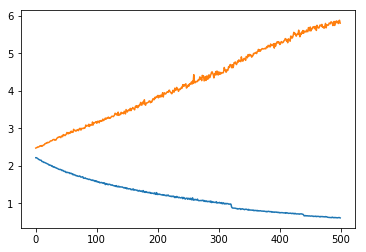

In [344]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
    
plt.plot(plot_losses_train, label='train loss')
plt.plot(plot_losses_eval, label='eval loss')
plt.show()

In [0]:
torch.cuda.empty_cache()

In [0]:
gpustat -p

# See how predictions are: 

In [397]:
import torch.optim as optim
load_name = 'simple_model_larger_encoder3_'

ENCODING_LSTM_OUTPUT=500
CODE_LAYER_SIZE=200
DECODING_LSTM_OUTPUT=500
#ENCODING_LSTM_OUTPUT=200
#CODE_LAYER_SIZE=200
VOCAB_SIZE=21
ENCODER_LSTM_NUM_LAYERS=2
DECODER_LSTM_NUM_LAYERS=2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

mem_pin = False
BATCH_SIZE = 32
epochs = 80
curr_ep = 1 # cant be 0 else later on there is division by zero!
learning_rate=0.001
clip=15

readout=False
allow_teacher_force = False
teaching_strategy = 'epoch' # can also be 'accuracy'

encoder_net = EncoderNet(ENCODING_LSTM_OUTPUT=ENCODING_LSTM_OUTPUT, CODE_LAYER_SIZE=CODE_LAYER_SIZE, 
                         VOCAB_SIZE=VOCAB_SIZE, ENCODER_LSTM_NUM_LAYERS=ENCODER_LSTM_NUM_LAYERS).to(device)
decoder_net = DecoderNet(DECODING_LSTM_OUTPUT=DECODING_LSTM_OUTPUT, CODE_LAYER_SIZE=CODE_LAYER_SIZE, 
                         VOCAB_SIZE=VOCAB_SIZE, DECODER_LSTM_NUM_LAYERS=DECODER_LSTM_NUM_LAYERS).to(device)
encoder_optimizer = optim.RMSprop(encoder_net.parameters(), lr=learning_rate)
decoder_optimizer = optim.RMSprop(decoder_net.parameters(), lr=learning_rate)

encoder_net, decoder_net,encoder_optimizer, decoder_optimizer, loss, e, best_eval_acc = loadModel(encoder_net, decoder_net,encoder_optimizer, decoder_optimizer, load_name, ignore_optim=True)

loaded in previous model!


In [0]:
sampler = BucketDataset(primary_train, BATCH_SIZE)
dataloader = DataLoader(df_train, batch_size=1, 
                        batch_sampler=sampler, shuffle=False,
                        num_workers=8, collate_fn=one_hotter, 
                        drop_last=False, pin_memory=mem_pin)

# Custom buckets and batch size because the CV dataset is so much smaller. 
evaluate_sampler = BucketDataset(primary_cv, BATCH_SIZE) # ,100,150,200,300,400
evaluate_dataloader = DataLoader(df_cv, batch_size=1, 
                    batch_sampler=evaluate_sampler, shuffle=False,
                    num_workers=8, collate_fn=one_hotter, 
                    drop_last=False, pin_memory=mem_pin)

In [400]:
with torch.no_grad():
    for cv_batch in dataloader:#evaluate_dataloader: 
        
        seqs = cv_batch[0].to(device)
        lengths = cv_batch[1].to(device)
        print(encoder_net(seqs, lengths))
        break

        eval_loss, eval_acc = train_forward(encoder_net, decoder_net, seqs,lengths, device, teacher_forcing=False, readout=readout, print_preds=True)

        #preds = train_forward(encoder_net, decoder_net, cv_batch, device, teacher_forcing=False, make_preds=True)
        #target = (cv_batch[0]).to(device)
        #seq_lengths = cv_batch[1]

RuntimeError: ignored

In [0]:
with torch.no_grad():
    for cv_batch in evaluate_dataloader: 
        print(encoder_net(cv_batch[0],cv_batch[1]))
        break

tensor([[-0.0023,  0.2183,  0.2718,  ..., -0.2392, -0.1695,  0.3490],
        [ 0.3124, -0.2415, -0.0100,  ..., -0.0135,  0.2223,  0.2753],
        [-0.0847, -0.3245,  0.2076,  ..., -0.1262,  0.4366, -0.0182],
        ...,
        [ 0.2962, -0.2558, -0.5093,  ..., -0.0022,  0.4100, -0.2511],
        [ 0.0118, -0.0047,  0.0222,  ...,  0.0563,  0.0715, -0.0719],
        [ 0.2619, -0.0094, -0.0852,  ...,  0.0934,  0.2698, -0.2786]],
       device='cuda:0')


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [0]:
ind=1
lens = seq_lengths[ind].item()
pred = torch.max(preds[ind,:,:], dim=1)[1][:lens]
pred

tensor([17, 14, 14, 19, 19, 19, 14, 14, 14, 19, 19, 19, 14, 14, 14, 19, 19, 19,
        14, 14, 14, 19, 19, 19, 14, 14, 19, 19, 14, 19, 14, 14, 19, 19, 14, 19,
        19, 14, 14, 19, 19, 14, 14, 19, 19, 19, 14, 14, 19, 14, 14, 19, 19, 19,
        19, 14, 14, 14, 14, 19, 19, 19, 19, 14, 14, 19, 14, 19, 19, 19, 14, 14,
        14, 19, 19, 19, 14, 19, 14, 14, 19, 19, 14, 19, 14, 19, 14, 19, 19, 19,
        14, 14, 14, 19, 19, 19, 14, 14, 14, 19, 19, 19, 14, 14, 19, 19, 14, 19,
        14, 19, 14, 19, 19, 14, 14, 19, 19, 19, 14, 14, 19, 19, 14, 14, 19, 19,
        14, 19, 14, 19, 14, 19, 19, 19, 14, 14, 14, 19, 19, 19, 19, 14, 14, 14,
        19, 19, 14, 19, 14, 19, 14, 19, 19, 19, 14, 14, 19, 19, 14, 14, 19, 19,
        14, 19, 14, 19, 14, 19, 19, 19, 14, 14, 14, 19, 14, 19, 19, 19, 14, 14,
        19, 19, 14, 14, 19, 19, 14, 19, 19, 14, 14, 19, 19, 14, 14, 19, 19, 14,
        14, 19, 19, 19, 14, 14, 14, 19, 19, 19, 14, 19, 14, 14, 19, 19, 14, 14,
        19, 19, 14, 19, 19, 19, 14, 14, 

In [0]:
pred.shape

torch.Size([468])

In [0]:
cv_batch[0].shape

torch.Size([32, 595, 21])

In [0]:
true = torch.max(cv_batch[0][ind,:,:], dim=1)[1][:lens]
true

tensor([11,  6, 16, 16,  7,  7,  7,  7,  7,  7, 11, 16, 16, 10,  9,  5, 18, 18,
        16, 16, 10,  3,  8,  8,  1,  1, 14,  1,  6, 15, 12,  9, 14, 10,  1,  4,
        10,  1,  4,  9,  1, 10,  1,  1,  8,  9,  4, 12,  3, 14, 14, 10, 13,  3,
        13,  4, 18, 18,  5,  1, 13, 10, 14, 10,  1, 17,  9, 16,  6, 17,  8, 13,
        10, 17, 17, 17,  1, 10,  3,  2,  8,  6,  9, 10,  8, 16, 20, 16, 20,  5,
        16,  1, 13, 16, 16, 16,  1, 17, 14,  3,  6, 17,  4, 14, 17, 13, 10,  8,
         4, 15,  1,  8,  3, 17,  8,  2,  3,  2,  5, 14,  6,  4, 17, 17, 10, 18,
         4,  8, 14, 10, 14,  8, 18,  9, 16, 10, 10,  1,  1, 18, 10, 12,  3,  9,
         8,  8, 18,  7,  6,  1,  6, 10, 10,  9,  1, 18, 15, 14, 18, 20, 12,  8,
         5, 10, 10, 16, 15, 16, 17,  1, 12, 14, 14, 18,  1, 14,  6, 17, 10, 17,
        14, 11, 18,  6, 17, 18,  5,  4, 15, 18,  9, 17, 15, 10,  7, 11,  9,  4,
         1, 15,  1, 12, 10,  6, 15, 10,  9,  1, 16, 15, 16, 16, 10,  1, 18,  3,
        15, 16,  3,  3, 14,  3, 16, 14, 

# Keras Same Architecture Encoder:

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class EncoderNet(nn.Module):

    def __init__(self, BATCH_SIZE = 64, ENCODING_LSTM_OUTPUT=200, CODE_LAYER_SIZE=300, VOCAB_SIZE=21):
        super(EncoderNet, self).__init__()
        #encoding
        self.encoder = nn.LSTM(input_size=VOCAB_SIZE, hidden_size= ENCODING_LSTM_OUTPUT,num_layers=1,bidirectional=True, batch_first=True)

    def forward(self, input, seq_len):
      
        # not clear to me if I want to have the latent space be repeated and given to every timestep of the LSTM?
        # Pack padded batch of sequences for RNN module
        res = torch.nn.utils.rnn.pack_padded_sequence(input, seq_len, batch_first=True).cuda()
        res, (hidden_h, hidden_c) = self.encoder(res)
        
        return torch.cat( (hidden_h[0,:,:],hidden_h[1,:,:]), dim=1)

encoder_net = EncoderNet()
print(encoder_net)

EncoderNet(
  (encoder): LSTM(21, 200, batch_first=True, bidirectional=True)
)


In [0]:
class DecoderNet(nn.Module):

    def __init__(self,CODE_LAYER_SIZE=300, VOCAB_SIZE=21, FIRST_LSTM_NUM_LAYERS=1, hidden_size=200):
        super(DecoderNet, self).__init__()
        #decode
        #self.dense1_predecode = nn.Linear(in_features=(CODE_LAYER_SIZE), out_features=50 )
        self.decoder = nn.LSTM(input_size=(CODE_LAYER_SIZE*2),bidirectional=True, hidden_size=hidden_size,num_layers=1, batch_first=True)
        self.dense1_dec = nn.Linear(in_features=400, out_features=100)
        self.dense2_dec = nn.Linear(in_features=100, out_features=VOCAB_SIZE )
        self.FIRST_LSTM_NUM_LAYERS=FIRST_LSTM_NUM_LAYERS
        self.CODE_LAYER_SIZE=CODE_LAYER_SIZE
        self.VOCAB_SIZE=VOCAB_SIZE
        self.hidden_size=hidden_size

    def forward(self, latent_space, hidden, seq_len):
        #decoding. takes in a single latent code from a single part of the batch. 
        # where input is the teacher forcing or the predictions from the previous step.
        
        #prev_out = torch.nn.utils.rnn.pack_padded_sequence(latent_space, seq_len, batch_first=True).cuda()
        prev_out, hidden = self.decoder( latent_space, hidden) 
        #prev_out, _ = torch.nn.utils.rnn.pad_packed_sequence(prev_out)
        prev_out = F.elu(self.dense1_dec(prev_out))
        prev_out = F.log_softmax(self.dense2_dec(prev_out), dim=2)
        return prev_out
    
    def initHidden(self, batch_size):
        return (torch.zeros([self.FIRST_LSTM_NUM_LAYERS,batch_size,int(self.hidden_size)], device=device),
                torch.zeros([self.FIRST_LSTM_NUM_LAYERS,batch_size,int(self.hidden_size)], device=device))

    def initHidden_Out(self, batch_size):
        return (torch.zeros([1,batch_size,self.VOCAB_SIZE], device=device),
                torch.zeros([1,batch_size,self.VOCAB_SIZE], device=device))

decoder_net = DecoderNet()
print(decoder_net)

DecoderNet(
  (decoder): LSTM(600, 200, batch_first=True, bidirectional=True)
  (dense1_dec): Linear(in_features=400, out_features=100, bias=True)
  (dense2_dec): Linear(in_features=100, out_features=21, bias=True)
)


# Other Random functions

In [0]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)
    
dump_tensors(gpu_only=False)

In [0]:
!nvidia-smi

Useful code to take: 

In [0]:
# interesting! 

def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [0]:
evaluateRandomly(encoder1, attn_decoder1)

In [0]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

# Data Amino Acids to integers

I have saved the vocabulary index also! 

## Beware that I have added one to everything!!!!!! When working with the data. As the padding value is 0. (previously... I am not using padding any more though!!)

In [0]:
import pickle
primary_train = pickle.load(open('training_primary.pickle', 'rb'))
primary_test = pickle.load(open('testing_primary.pickle', 'rb'))
primary_cv = pickle.load(open('validation_primary.pickle', 'rb'))
#pickle.dump(primary, open('training_primary.pickle', 'wb'))

In [0]:
vocab = set()
for seq in primary_train:
  #temp = set((list(seq)))
  vocab.update( set((list(seq))) )
print(len(list(vocab)))
# => ['<pad>', '_', 'd', 'e', 'g', 'i', 'l', 'm', 'n', 'o', 'r', 's', 't', 'u', 'y']
vocab = sorted(vocab)

In [0]:
#vocab = sorted(set([  c for c in seqs for seqs in primary_train])) #sorted(set([char for seq in primary for char in primary_train]))
def chars_to_ints(sequences, vocab):
  return np.asarray( [np.asarray(s) for s in [[vocab.index(tok) for tok in seq] for seq in sequences]])

In [0]:
primary_train = chars_to_ints(primary_train, vocab)
primary_cv  = chars_to_ints(primary_cv, vocab)
primary_test  = chars_to_ints(primary_test, vocab)

In [0]:
primary_test.shape 

In [0]:
#pickle.dump(vocab, open('sorted_vocab_encoding.pickle', 'wb'))

In [0]:
'''pickle.dump(primary_train, open('training_primary_ints.pickle', 'wb'))
pickle.dump(primary_test, open('testing_primary_ints.pickle', 'wb'))
pickle.dump(primary_cv, open('validation_primary_ints.pickle', 'wb'))'''


# Teacher Forcing Friendly Encoder and Decoder. 

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class EncoderNet(nn.Module):

    def __init__(self, ENCODING_LSTM_OUTPUT=100, CODE_LAYER_SIZE=50, VOCAB_SIZE=20, ENCODER_LSTM_NUM_LAYERS=2 ):
        super(EncoderNet, self).__init__()
        #encoding
        self.LSTM_NUM_LAYERS = ENCODER_LSTM_NUM_LAYERS
        self.ENCODING_LSTM_OUTPUT = ENCODING_LSTM_OUTPUT
        self.encoder = nn.LSTM(input_size=VOCAB_SIZE, hidden_size= self.ENCODING_LSTM_OUTPUT,num_layers=self.LSTM_NUM_LAYERS,bidirectional=True, batch_first=True)
        #self.batchnorm = nn.BatchNorm1d(ENCODING_LSTM_OUTPUT * 2* self.LSTM_NUM_LAYERS) # as either 2 layers OR I concat them
        self.dense1_enc = nn.Linear(in_features=(ENCODING_LSTM_OUTPUT* 2 ), out_features=CODE_LAYER_SIZE ) # * self.LSTM_NUM_LAYERS because it is bidirectional
        self.dense2_enc = nn.Linear(in_features=CODE_LAYER_SIZE, out_features=CODE_LAYER_SIZE )
        if self.LSTM_NUM_LAYERS >2:
            print('WARNING, LSTM ENCODER HAS MORE THAN 2 LAYER, will need to change how hidden layers are concatenated!')

    def forward(self, input, seq_len):
        #print('encoder input', input)
        #print('sequence length', seq_len)
        # Pack padded batch of sequences for RNN module
        #res = torch.nn.utils.rnn.pack_padded_sequence(input, seq_len, batch_first=True).cuda()
        res, (hidden_h, hidden_c) = self.encoder(input)
        #res = torch.nn.utils.rnn.pad_packed_sequence(res, batch_first=True).cuda() # only use if I want the output w/ all timesteps for the LSTM
        # combine the bidirectional outputs, concatenate states from separate layers. 
        #print('hidden encoder that i concat', hidden_h.shape)
        
        res = torch.mean(res, dim=1)
        
        #res = res.view(self.LSTM_NUM_LAYERS, 2, input.shape[0], self.ENCODING_LSTM_OUTPUT)
        
        '''if self.LSTM_NUM_LAYERS ==2:
            #res = hidden_h.view(self.LSTM_NUM_LAYERS, 2, input.shape[0], self.ENCODING_LSTM_OUTPUT)
            
            # may be much more efficient ways to do this:
            res = torch.cat( (torch.cat( (res[0,0,:,:], res[0,1,:,:]) ,1), torch.cat( (res[1,0,:,:], res[1,1,:,:]) ,1) ), 1)
            #res= torch.cat( (torch.add(torch.mean(res[0,:,:], dim=),hidden_h[1,:,:]),torch.add(hidden_h[2,:,:],hidden_h[3,:,:])), 1)
        else: 
            # average over all of the hidden states!
            print(res.shape)
            # res = torch.mean( res, dim=1)
            torch.cat((hidden_h[0,:,:],hidden_h[1,:,:]), 1) '''
        #res = self.batchnorm(res)
        res = self.dense2_enc(F.elu(self.dense1_enc(res))) # used to have F.tanh here!
        return res

encoder_net = EncoderNet()
print(encoder_net)

EncoderNet(
  (encoder): LSTM(20, 100, num_layers=2, batch_first=True, bidirectional=True)
  (dense1_enc): Linear(in_features=200, out_features=50, bias=True)
  (dense2_enc): Linear(in_features=50, out_features=50, bias=True)
)


In [0]:
class DecoderNet(nn.Module):

    def __init__(self, DECODING_LSTM_OUTPUT=100, CODE_LAYER_SIZE=50, VOCAB_SIZE=20, DECODER_LSTM_NUM_LAYERS=1 ):
        super(DecoderNet, self).__init__()
        #decode it should be the inverse of the encoder!
        #self.dense1_predecode = nn.Linear(in_features=(CODE_LAYER_SIZE), out_features=50 )
        #self.dense1_pre_dec = nn.Linear(in_features=(CODE_LAYER_SIZE), out_features=200 )
        self.LSTM_OUTPUT_SIZE = DECODING_LSTM_OUTPUT
        #self.decoder_out = nn.LSTM(input_size=int(CODE_LAYER_SIZE/2),bidirectional=False, hidden_size=VOCAB_SIZE,num_layers=1, batch_first=True)
        self.LSTM_NUM_LAYERS=DECODER_LSTM_NUM_LAYERS
        self.CODE_LAYER_SIZE=CODE_LAYER_SIZE
        self.VOCAB_SIZE=VOCAB_SIZE
        self.decoder = nn.LSTM(input_size=( (CODE_LAYER_SIZE)+VOCAB_SIZE),bidirectional=False, #I NEED TO BE PASSING IN THE WHOLE ONE HOT VECTOR AGAIN!
                               hidden_size=self.LSTM_OUTPUT_SIZE,num_layers=self.LSTM_NUM_LAYERS, batch_first=True)
        # should be half the size but the LSTM is bidirectional. 
        #self.batchnorm = nn.BatchNorm1d(self.LSTM_OUTPUT_SIZE)
        self.dense1_post_dec = nn.Linear(in_features=(self.LSTM_OUTPUT_SIZE), out_features=50 )
        self.dense2_post_dec = nn.Linear(in_features=50, out_features=VOCAB_SIZE )
        #self.dense3_post_dec = nn.Linear(in_features=50, out_features=VOCAB_SIZE )

    def forward(self, latent_space, prev_out, hidden):
        #decoding. takes in a single latent code from a single part of the batch. 
        # where input is the teacher forcing or the predictions from the previous step.

        prev_out, hidden = self.decoder( torch.cat( (latent_space, prev_out ), 2 ), hidden)
        
        #print('batch norm ', prev_out.shape)
        #prev_out = self.batchnorm(prev_out.permute([0,2,1])).permute([0,2,1]).contiguous()
        #print('batch norm ', prev_out.shape)
        prev_out = F.elu(self.dense1_post_dec(prev_out))
        prev_out = F.log_softmax(self.dense2_post_dec(prev_out), dim=2)
        return prev_out, hidden
    
    def initHidden(self, batch_size):
        hidden_h = torch.empty([self.LSTM_NUM_LAYERS,batch_size,int(self.LSTM_OUTPUT_SIZE)], device=device)
        torch.nn.init.orthogonal_(hidden_h, gain=nn.init.calculate_gain('tanh'))
        return (hidden_h,
                torch.zeros([self.LSTM_NUM_LAYERS,batch_size,int(self.LSTM_OUTPUT_SIZE)], device=device))

'''   def initHidden_Out(self, batch_size):
        return (torch.zeros([1,batch_size,self.VOCAB_SIZE], device=device),
                torch.zeros([1,batch_size,self.VOCAB_SIZE], device=device))'''

decoder_net = DecoderNet()
print(decoder_net)

DecoderNet(
  (decoder): LSTM(51, 100, batch_first=True)
  (batchnorm): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense1_post_dec): Linear(in_features=100, out_features=50, bias=True)
  (dense2_post_dec): Linear(in_features=50, out_features=20, bias=True)
)


# Original Bucket by Seq Length and padder:

In [0]:
import numpy as np
from random import shuffle

class BySequenceLengthSampler(Sampler):

    def __init__(self, data_source,  
                bucket_boundaries, batch_size=64,):
        ind_n_len = []
        for i, p in enumerate(data_source):
            ind_n_len.append( (i, p.shape[0]) )
        self.ind_n_len = ind_n_len
        self.bucket_boundaries = bucket_boundaries
        self.batch_size = batch_size
        
        
    def __iter__(self):
        print('bucketing the data again!!! ===========')
        data_buckets = dict()
        # where p is the id number and seq_len is the length of this id number. 
        record = []
        for p, seq_len in self.ind_n_len:
            pid = self.element_to_bucket_id(p,seq_len)
            if pid in data_buckets.keys():
                data_buckets[pid].append(p)
            else:
                data_buckets[pid] = [p]

        for k in data_buckets.keys():
            data_buckets[k] = np.asarray(data_buckets[k])
            record.append((k , data_buckets[k].shape[0]))
        print(record)
        iter_list = []
        for k in data_buckets.keys():
            np.random.shuffle(data_buckets[k])
            iter_list += (np.array_split(data_buckets[k]
                           , int(data_buckets[k].shape[0]/self.batch_size)))
        shuffle(iter_list) # shuffle all the batches so they arent ordered by bucket
        # size
        for i in iter_list: 
            yield i.tolist() # as it was stored in an array
    
    def __len__(self):
        return len(self.data_source)
    
    def element_to_bucket_id(self, x, seq_length):
        boundaries = list(self.bucket_boundaries)
        buckets_min = [np.iinfo(np.int32).min] + boundaries
        buckets_max = boundaries + [np.iinfo(np.int32).max]
        conditions_c = np.logical_and(
          np.less_equal(buckets_min, seq_length),
          np.less(seq_length, buckets_max))
        bucket_id = np.min(np.where(conditions_c))
        return bucket_id



In [0]:
def sort_batch(batch, lengths):
    """
    Sort a minibatch by the length of the sequences with the longest sequences first
    return the sorted batch targes and sequence lengths.
    This way the output can be used by pack_padded_sequences(...)
    """
    seq_lengths, perm_idx = lengths.sort(0, descending=True)
    seq_tensor = batch[perm_idx]
    return seq_tensor, seq_lengths

def pad_and_sort_batch(DataLoaderBatch):
    """
    DataLoaderBatch should be a list of (sequence, target, length) tuples...
    Returns a padded tensor of sequences sorted from longest to shortest, 
    """
    vocab_size = 21
    batch_size = len(DataLoaderBatch)
    batch_split = list(zip(*DataLoaderBatch))

    seqs, lengths = batch_split[0], batch_split[1]
    max_length = max(lengths)
    
    padded_seqs = np.zeros((batch_size, max_length))
    for i, l in enumerate(lengths):
        padded_seqs[i, 0:l] = seqs[i][0:l]
    
    #print(padded_seqs)
    #print('seq') write it as sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)
    y = torch.tensor(padded_seqs).type(torch.LongTensor) #had device
    y_onehot = torch.FloatTensor(batch_size, max_length, vocab_size)
    y_onehot.zero_()
    y_onehot.scatter_(2, torch.unsqueeze(y, 2), 1.0)
    #print('max')
    #print(y_onehot.max(dim=2)[1])
    return sort_batch(y_onehot, torch.tensor(lengths)) # had device

In [0]:
bucket_boundaries = [50,75,100]#,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500] #,700]#,800,900,1000,1100,1200]
    sampler = BySequenceLengthSampler(primary_train,bucket_boundaries, BATCH_SIZE)
    dataloader = DataLoader(df_train, batch_size=1, 
                            batch_sampler=sampler, shuffle=False,
                            num_workers=8, collate_fn=pad_and_sort_batch, 
                            drop_last=False, pin_memory=mem_pin)